# Import & loading data

In [1]:
#Imports
from modules.preamble import *
from sklearn.metrics import roc_auc_score, roc_curve
import json
import pickle

from modules.PFS import PFS_layer, PFS_CP
from modules.kappa import *
from modules.RNN_utils import *

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\KevinReijnders\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
#Load the 6 models from memory
pfs_cp = pickle.load(open(os.path.join(data_base_path, 'final_models', 'pfs_cp.pickle'),
                          'rb'))
pfs_ml = pickle.load(open(os.path.join(data_base_path, 'final_models', 'pfs_ml.pickle'),
                          'rb'))

dnn_all_feats = tf.keras.models.load_model(os.path.join(data_base_path, 'final_models', 'dnn_all_feats'))
dnn_pfs_feats = tf.keras.models.load_model(os.path.join(data_base_path, 'final_models', 'dnn_pfs_feats'))

gru_all_feats = tf.keras.models.load_model(os.path.join(data_base_path, 'final_models', 'gru_all_feats'))
gru_pfs_feats = tf.keras.models.load_model(os.path.join(data_base_path, 'final_models', 'gru_pfs_feats'))

all_models = [pfs_cp, pfs_ml, dnn_all_feats, dnn_pfs_feats, gru_all_feats, gru_pfs_feats]
modelnames = ['PFS-CP', 'PFS-ML', 'DNN (all features)', 'DNN (7 features)', 'GRU (all features)', 'GRU (7 features)']

In [4]:
#Load the data
df_train = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/df_train.hdf'))
df_val = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/df_val.hdf'))
df_test = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/df_test.hdf'))
df_test_w_preds = pd.read_hdf(os.path.join(data_base_path, 'modeling_data', 'df_test_with_predictions.hdf'))

X_train = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/X_train.hdf')).values
X_val = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/X_val.hdf')).values
X_test = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/X_test.hdf')).values

y_train = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/y_train.hdf')).values.ravel() #flat
y_val = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/y_val.hdf')).values.ravel()
y_test = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/y_test.hdf')).values.ravel()

instance_weights_train = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/instance_weights_train.hdf')).values.ravel()

with open(os.path.join(data_base_path, 'modeling_data', 'optimal_thresholds_kappa_curve.json'), 'r') as f:
    opt_thres = json.load(f)

In [5]:
#Means & stds of each feature to reverse the normalization
means = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/means.hdf')).values
stds = pd.read_hdf(os.path.join(data_base_path, 'modeling_data/stds.hdf')).values

In [6]:
#Retrieve best pfs config
with open(os.path.join(data_base_path, 'model_tuning', 'Best-PFS-config.json'), 'r') as f:
    best_pfs_config = json.load(f)

In [7]:
pfs_feats_indices = best_pfs_config['feature_indices'] #Store feature indices for later usage
best_pfs_config

{'n_features': 7,
 'feature_indices': [13, 19, 14, 17, 5, 25, 11],
 'feature_names': ['got(asat)',
  'ptt',
  'gpt(alat)',
  'platelets',
  'bilirubin',
  'white blood cells',
  'fio2'],
 'n_rules': 4,
 'seed': 39,
 'cluster_type': 'k-means'}

In [8]:
feature_names = ['GOT(ASAT)', 'PTT', 'GPT(ALAT)', 'Platelets', 'Bilirubin', 'White blood cells', 'FiO2'] #Properly capitalized feature names

# PFS-specific inquiry

## Tables with centers, widths and conditional probabilities

In [9]:
#Create a table of centers & widths, both normalized & with reversing the normalization of the scale
centers_or = (pfs_ml.cluster_centers_ * stds[pfs_feats_indices].T) + means[pfs_feats_indices].T
widths_or = (pfs_ml.widths_ * stds[pfs_feats_indices].T) + means[pfs_feats_indices].T

rules_ind = np.array([[i for j in range(7)] for i in range(1,5)]).ravel()
rules_ind = ['Rule {}'.format(rulenr) for rulenr in rules_ind] #Store in an easier-to-interpret format for in the table
feat_ind = np.array(best_pfs_config['feature_names']*4)

#Retrieve quantiles corresponding to center values
quantiles = []
for (feat, center_val) in zip(feat_ind, centers_or.ravel()):
    quantile = (df_train[feat].dropna() <= center_val).mean()
    quantiles.append(quantile)

df_cw = pd.DataFrame([feature_names*4, rules_ind, pfs_ml.cluster_centers_.ravel(), pfs_ml.widths_.ravel(), centers_or.ravel(), widths_or.ravel(), quantiles],
                     index=['Feature', 'Rule Number', '$v_j$', '$\sigma_j$',
                            '$v_j$ (Original Scale)', '$\sigma_j$ (Original Scale)', 'Quantile corresponding to $v_j$']).T

df_cw.sort_values(["Feature", "Rule Number"], inplace=True)
pd.options.display.float_format = '{:,.2f}'.format
df_cw

Feature Rule Number $v_j$ $\sigma_j$ $v_j$ (Original Scale)  \
4           Bilirubin      Rule 1 -0.58       2.77                  -0.62   
11          Bilirubin      Rule 2 -1.03       1.34                  -3.02   
18          Bilirubin      Rule 3  1.65      15.80                  11.21   
25          Bilirubin      Rule 4  1.91       3.35                  12.58   
6                FiO2      Rule 1 -1.14       1.40                  31.66   
13               FiO2      Rule 2 -1.10       3.48                  32.31   
20               FiO2      Rule 3  2.88      14.31                  97.50   
27               FiO2      Rule 4 -1.77       2.96                  21.34   
0           GOT(ASAT)      Rule 1 -0.92       1.05                -445.08   
7           GOT(ASAT)      Rule 2 -1.00       1.15                -500.63   
14          GOT(ASAT)      Rule 3 13.85      15.89               8,685.38   
21          GOT(ASAT)      Rule 4  0.73       3.53                 570.91   
2           GPT(ALAT)      Rule 1 -0.43       2.79                 -44.73   
9           GPT(ALAT)      Rule 2 -0.60       2.31                 -92.62   
16          GPT(ALAT)      Rule 3 11.86      16.09               3,519.15   
23          GPT(ALAT)      Rule 4  3.19       4.71               1,006.15   
1                 PTT      Rule 1 -1.24       1.04                  15.99   
8                 PTT      Rule 2  1.13       3.62                  64.24   
15                PTT      Rule 3  2.08      14.92                  83.58   
22                PTT      Rule 4 -1.59       2.00                   8.87   
3           Platelets      Rule 1  0.56       3.25                 317.78   
10          Platelets      Rule 2  1.86       2.05                 525.05   
17          Platelets      Rule 3 -1.96      14.58                 -84.43   
24          Platelets      Rule 4  0.15       3.06                 252.35   
5   White blood cells      Rule 1 -0.32       2.29                   9.88   
12  White blood cells      Rule 2 -0.12       0.98                  11.66   
19  White blood cells      Rule 3  1.00      15.66                  21.74   
26  White blood cells      Rule 4  1.45       4.55                  25.72   

   $\sigma_j$ (Original Scale) Quantile corresponding to $v_j$  
4                        17.17                            0.00  
11                        9.58                            0.00  
18                       86.41                            0.95  
25                       20.27                            0.95  
6                        73.28                            0.03  
13                      107.24                            0.03  
20                      284.59                            0.95  
27                       98.80                            0.01  
0                       772.60                            0.00  
7                       834.57                            0.00  
14                    9,945.53                            1.00  
21                    2,303.47                            0.97  
2                       889.09                            0.00  
9                       750.56                            0.00  
16                    4,744.67                            1.00  
23                    1,445.76                            0.99  
1                        62.34                            0.00  
8                       114.85                            0.90  
15                      344.79                            0.96  
22                       81.96                            0.00  
3                       747.69                            0.75  
10                      556.58                            0.95  
17                    2,558.35                            0.00  
24                      718.25                            0.63  
5                        33.29                            0.44  
12                       21.50                            0.55  
19                      1

In [10]:
df_cp = pd.DataFrame(pfs_ml.cond_probs_, index=['Rule 1', 'Rule 2', 'Rule 3', 'Rule 4'], columns=['Class 0 (Survives next 72h)', 'Class 1 (Mortality within 72h)'])
df_cp

Class 0 (Survives next 72h)  Class 1 (Mortality within 72h)
Rule 1                         0.95                            0.05
Rule 2                         0.89                            0.11
Rule 3                         0.04                            0.96
Rule 4                         0.54                            0.46

## Visualizations of the rules on the features

(0.0, 1.0, 0.0, 1.0)

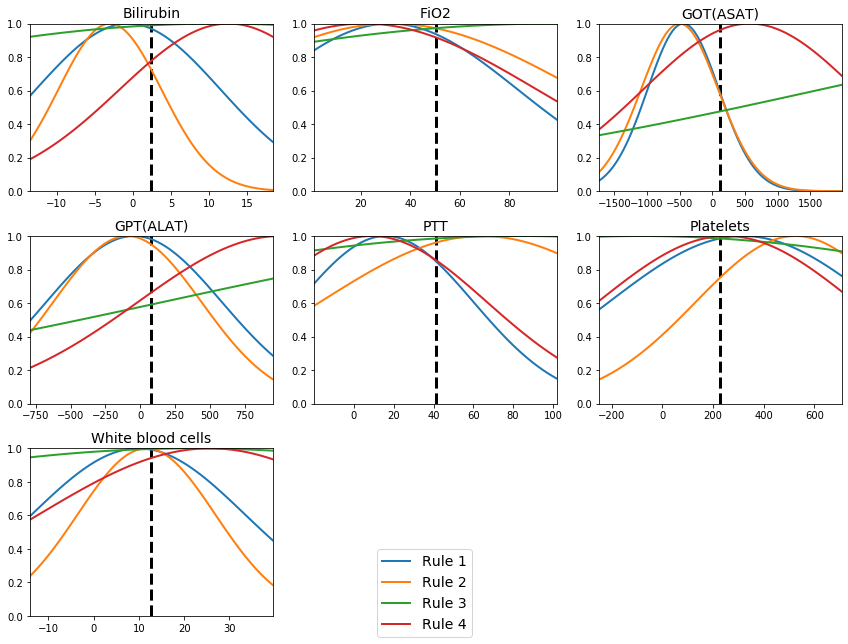

In [11]:
#Retrieve min and max center of each feature
min_centers = df_cw.groupby('Feature')['$v_j$ (Original Scale)'].min()
max_centers = df_cw.groupby('Feature')['$v_j$ (Original Scale)'].max()

#Retrieve means & stds
feat_means = pd.Series(means[pfs_feats_indices].ravel(), feature_names)
feat_stds = pd.Series(stds[pfs_feats_indices].ravel(), feature_names)

fig, ax = plt.subplots(3,3, figsize=(12,9))
fig_indices = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0]]

for feature, fig_index in zip(max_centers.index, fig_indices):
    #Retrieve min & max & evenly spaced x coordinates in that range
    min_val = feat_means[feature] - 3 * feat_stds[feature]
    max_val = feat_means[feature] + 3 * feat_stds[feature]
    X = np.linspace(min_val, max_val, 100)
    ax[fig_index[0], fig_index[1]].set_title(feature, fontsize=14)
    ax[fig_index[0], fig_index[1]].axvline(feat_means[feature], linestyle='--', color='black', linewidth=3)
    ax[fig_index[0], fig_index[1]].set_xlim(min_val,max_val)
    ax[fig_index[0], fig_index[1]].set_ylim(0,1)
    handles, labels = ax[1,1].get_legend_handles_labels()

    for rule in df_cw['Rule Number'].unique():
        center = df_cw[ (df_cw['Rule Number']== rule) & (df_cw['Feature']==feature)]['$v_j$ (Original Scale)'].values[0]
        width = df_cw[ (df_cw['Rule Number']== rule) & (df_cw['Feature']==feature)]['$\sigma_j$ (Original Scale)'].values[0]
        
        #Calculate normalized membership values
        memb_vals = np.exp( -(X-center)**2 / width**2)

        ax[fig_index[0], fig_index[1]].plot(X,memb_vals,label=rule, linewidth=2)
        
fig.tight_layout()

fig.legend(handles, labels, loc='lower center', fontsize=14)
ax[2,1].axis('off')
ax[2,2].axis('off')

# fig.savefig(os.path.join(figs_base_path, 'pfs-rules-vis.png'),
#             dpi=200)

## Redundancy/irrelevance
We compute these on the test set

In [12]:
X_memb_vals = pfs_ml.calc_mf(X_test[:, pfs_feats_indices]) #Compute membership function values of each observations for all the rules
X_memb_vals = np.hstack((X_memb_vals, np.array([[1] for i in range(X_memb_vals.shape[0])]))) #Add the MF values of the universal set, i.e. always 1

similarities = []
for rule1 in range(X_memb_vals.shape[1]):
    row_similarities = []
    for rule2 in range(X_memb_vals.shape[1]):
        inters = X_memb_vals[:,[rule1, rule2]].min(axis=1)
        union = X_memb_vals[:,[rule1, rule2]].max(axis=1)
        row_similarities.append(inters.sum() / union.sum())

    similarities.append(row_similarities)

In [13]:
pd.DataFrame(similarities, index=['Rule 1', 'Rule 2', 'Rule 3', 'Rule 4', 'Universal Set'], columns=['Rule 1', 'Rule 2', 'Rule 3', 'Rule 4', 'Universal Set'])

Rule 1  Rule 2  Rule 3  Rule 4  Universal Set
Rule 1           1.00    0.38    0.33    0.54           0.10
Rule 2           0.38    1.00    0.27    0.33           0.07
Rule 3           0.33    0.27    1.00    0.51           0.25
Rule 4           0.54    0.33    0.51    1.00           0.13
Universal Set    0.10    0.07    0.25    0.13           1.00

In [15]:
#How come that Rule 4 is still so dissimilar to the universal set? Let's view statistics on membership values
pd.DataFrame(X_memb_vals, columns=['Rule 1', 'Rule 2', 'Rule 3', 'Rule 4', 'Universal Set']).describe()

Rule 1     Rule 2     Rule 3     Rule 4  Universal Set
count 118,967.00 118,967.00 118,967.00 118,967.00     118,967.00
mean        0.10       0.07       0.25       0.13           1.00
std         0.10       0.08       0.06       0.08           0.00
min         0.00       0.00       0.14       0.00           1.00
25%         0.00       0.01       0.23       0.07           1.00
50%         0.06       0.04       0.24       0.14           1.00
75%         0.16       0.11       0.25       0.19           1.00
max         0.54       0.43       0.96       0.54           1.00

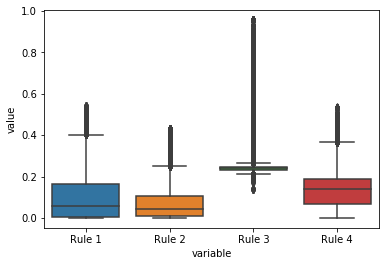

In [16]:
#Let's see this as a boxplot
sns.boxplot(x='variable',
            y='value',
            data=pd.melt(pd.DataFrame(X_memb_vals, columns=['Rule 1', 'Rule 2', 'Rule 3', 'Rule 4', 'Universal Set']).drop('Universal Set', axis=1)))

# Permutation feature importance

In [95]:
#Retrieve feature importances for each feature and each model, both for ROC-AUC and AUK
#Runs in a few minutes
from eli5.permutation_importance import get_score_importances

all_models_perm_imps = []
for i, model in enumerate(all_models):
    print(i)
    if (i<2): #Then we have a PFS
        def score_func(X,y):
            y_score = model.predict_proba(X)[:,1]
            return roc_auc_score(y, y_score), auk_score(y, y_score)
    elif (i<4): #Then we have a DNN
        def score_func(X,y):
            y_score = model.predict(X)
            return roc_auc_score(y, y_score), auk_score(y, y_score)
    else: 
        def score_func(X,y):
            X_seq = to_seq(df_test, 'subject_id', X) #Convert X to sequences format for RNN predictions
            y_score = predict_for_sequences(model, X_seq) #Generate flattened prediction array for the RNN using the workaround
            return roc_auc_score(y, y_score), auk_score(y, y_score)

    #Retrieve permutation importances with eli5 function
    if (i<2) | (i==3) | (i==5): #Then we have a PFS or DL model with pfs features
        perm_imps = get_score_importances(score_func, X_test[:,pfs_feats_indices], y_test, n_iter=1, random_state=10)[1][0]
    else: #Then we have a DL model with all features
        perm_imps = get_score_importances(score_func, X_test, y_test, n_iter=1, random_state=10)[1][0]

    #Take the mean of the importances of the 3 iterations & store the results
    all_models_perm_imps.append(perm_imps)

Using TensorFlow backend.
0
1
2
3
4
5


In [96]:
#Overview of ROC-AUCs in a dataframe for convenient analysis
pd.options.display.float_format = '{:,.4f}'.format #More decimals to make differences between features & models clearer

#First fill the df with the models with all features
df_perm_imp = pd.DataFrame(
    [all_models_perm_imps[2][:,0], all_models_perm_imps[-2][:,0]],
    index=[modelnames[2], modelnames[-2]],
    columns=df_train.columns[2:-3]
)

#Now fill in the ROC-AUCs of the models with the 7 features from the PFS
lowcase_pfs_featnames = [feature_name.lower() for feature_name in feature_names]
for i in [0,1,3,5]:
    df_perm_imp.loc[modelnames[i], lowcase_pfs_featnames] = all_models_perm_imps[i][:,0]

df_perm_imp = df_perm_imp.T #Features in the rows rather than columns
df_perm_imp

DNN (all features)  GRU (all features)  PFS-CP  \
arterial base excess                  0.0046              0.0013     nan   
arterial pco2                         0.0028              0.0017     nan   
arterial ph                           0.0070              0.0077     nan   
arterial po2                         -0.0028             -0.0021     nan   
bicarbonate                           0.0086              0.0012     nan   
bilirubin                             0.0076              0.0028  0.0161   
calcium                               0.0025             -0.0008     nan   
creatinine                            0.0056             -0.0018     nan   
crp                                   0.0011              0.0006     nan   
cvp                                  -0.0041             -0.0022     nan   
diastolic blood pressure              0.0076              0.0096     nan   
fio2                                  0.0056              0.0043  0.0458   
glucose                              -0.0001              0.0003     nan   
got(asat)                             0.0106              0.0034  0.0074   
gpt(alat)                             0.0027              0.0009 -0.0005   
heart rate                            0.0078              0.0041     nan   
hematocrit                            0.0025             -0.0026     nan   
platelets                             0.0088             -0.0006  0.0015   
potassium                             0.0055              0.0034     nan   
ptt                                   0.0052              0.0044  0.0108   
sodium                                0.0015              0.0018     nan   
spo2                                  0.0151              0.0111     nan   
systolic blood pressure               0.0163              0.0129     nan   
temperature                           0.0053              0.0006     nan   
urea                                  0.0175              0.0076     nan   
white blood cells                     0.0062             -0.0015  0.0137   

                          PFS-ML  DNN (7 features)  GRU (7 features)  
arterial base excess         nan               nan               nan  
arterial pco2                nan               nan               nan  
arterial ph                  nan               nan               nan  
arterial po2                 nan               nan               nan  
bicarbonate                  nan               nan               nan  
bilirubin                 0.0068            0.0046            0.0079  
calcium                      nan               nan               nan  
creatinine                   nan               nan               nan  
crp                          nan               nan               nan  
cvp                          nan               nan               nan  
diastolic blood pressure     nan               nan               nan  
fio2                      0.0435            0.0401            0.0368  
glucose                      nan               nan               nan  
got(asat)                 0.0121            0.0572            0.0052  
gpt(alat)                 0.0016            0.0283            0.0002  
heart rate                   nan               nan               nan  
hematocrit                   nan               nan               nan  
platelets                 0.0081            0.0244           -0.0042  
potassium                    nan               nan               nan  
ptt                       0.0294            0.0188            0.0039  
sodium                       nan               nan               nan  
spo2                         nan               nan               nan  
systolic blood pressure      nan               nan               nan  
temperature                  nan               nan               nan  
urea                         nan               nan               nan  
white blood cells         0.0215            0.0235            0.0037

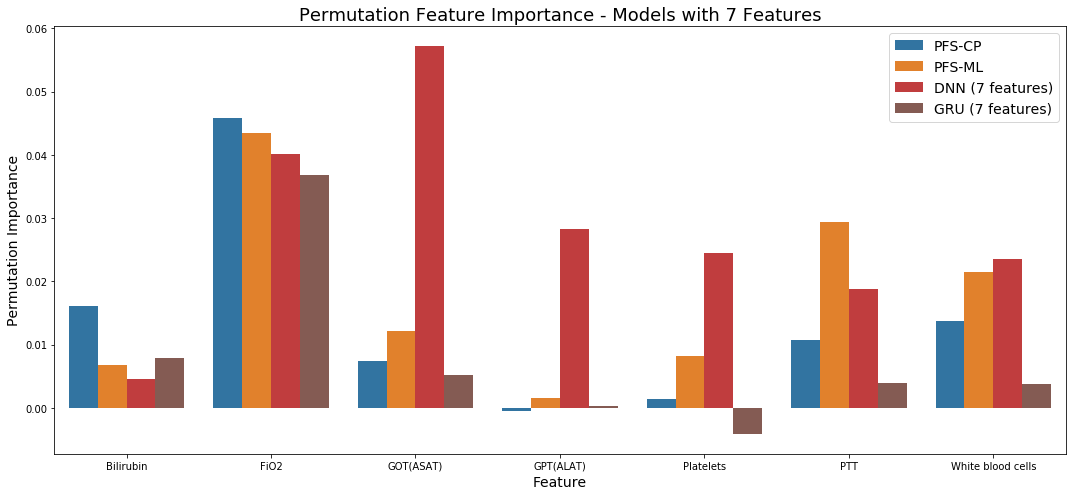

In [113]:
#Plot permutation importance on ROC-AUC for the models with the 7 features

#Store default colors to preserve same colors across figures
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors_dict = {
    'PFS-CP': colors[0],
    'PFS-ML': colors[1],
    'DNN (7 features)': colors[3],
    'GRU (7 features)': colors[5]
}

#Data processing to the right format for plotting
df_perm_imp_long = pd.melt(df_perm_imp[['PFS-CP', 'PFS-ML', 'DNN (7 features)', 'GRU (7 features)']], value_name='Permutation Importance', var_name='Model')
df_perm_imp_long.index = 4*df_perm_imp.index.tolist() #Set the index to be the proper variable names
df_perm_imp_long.dropna(inplace=True)
df_perm_imp_long.reset_index(inplace=True)
df_perm_imp_long.rename(columns={'index':'Feature'}, inplace=True)
df_perm_imp_long['Feature'] = df_perm_imp_long['Feature'].map({feature_name.lower():feature_name for feature_name in feature_names}) #Properly capitalized names of the features

#Actual plot
fig, ax = plt.subplots(1,1, figsize=(15,7))
sns.barplot(x='Feature', y='Permutation Importance', hue='Model', data=df_perm_imp_long, ax=ax, palette=colors_dict)

ax.set_title("Permutation Feature Importance - Models with 7 Features", fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
ax.legend(fontsize=14)

fig.tight_layout()
# fig.savefig(os.path.join(figs_base_path,'perm-feat-imp-7-feats.png'),
#             dpi=200)

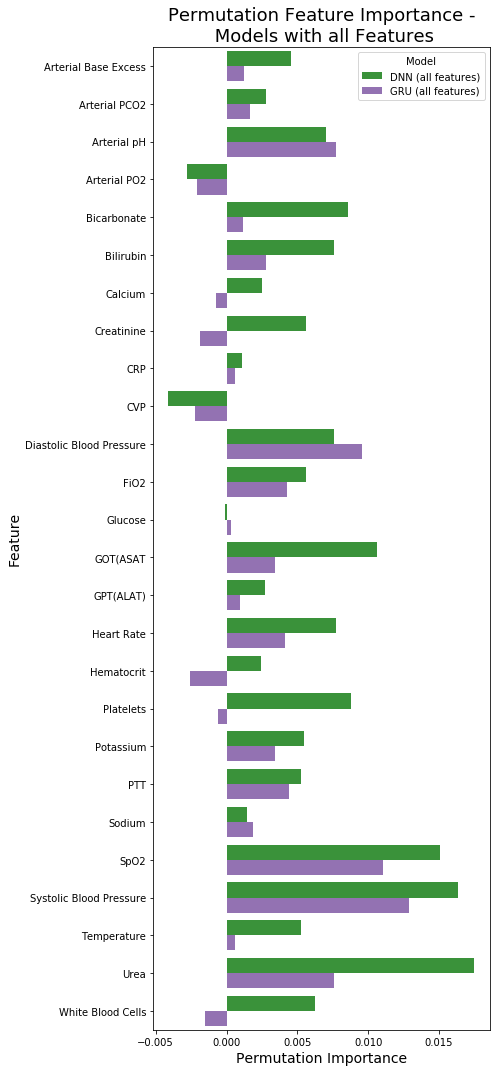

In [116]:
#Plot permutation importance on ROC-AUC for the models with all features

#Data processing to the right format for plotting
df_perm_imp_long = pd.melt(df_perm_imp[['DNN (all features)', 'GRU (all features)']], value_name='Permutation Importance', var_name='Model')
df_perm_imp_long.index = 2*df_perm_imp.index.tolist() #Set the index to be the proper variable names
df_perm_imp_long.dropna(inplace=True)
df_perm_imp_long.reset_index(inplace=True)
df_perm_imp_long.rename(columns={'index':'Feature'}, inplace=True)

#Correct names of the features
df_perm_imp_long['Feature'] = df_perm_imp_long['Feature'].apply(lambda x: x.title())
manual_featname_corrections = {'Arterial Pco2': 'Arterial PCO2', 
                               'Arterial Ph': 'Arterial pH',
                               'Arterial Po2': 'Arterial PO2',
                               'Crp':'CRP',
                               'Cvp':'CVP',
                               'Fio2':'FiO2',
                               'Got(Asat)':'GOT(ASAT',
                               'Gpt(Alat)':'GPT(ALAT)',
                               'Ptt':'PTT',
                               'Spo2':'SpO2'}
def correct_name(name):
    if name in manual_featname_corrections.keys():
        return manual_featname_corrections[name]
    else:
        return name
df_perm_imp_long['Feature'] = df_perm_imp_long['Feature'].apply(correct_name)

#Actual plot
fig, ax = plt.subplots(1,1, figsize=(7,15))
colors_dict = {
    'DNN (all features)': colors[2],
    'GRU (all features)': colors[4]
}
sns.barplot(x='Permutation Importance', y='Feature', hue='Model', data=df_perm_imp_long, ax=ax, orient='h', palette=colors_dict)
fig.tight_layout()

ax.set_title("Permutation Feature Importance -\n Models with all Features", fontsize=18)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(14)
# ax.legend(fontsize=14)

fig.tight_layout()
# fig.savefig(os.path.join(figs_base_path,'perm-feat-imp-all-feats.png'),
#             dpi=200)

# Accumulated local effects (ALE) plots
Leave out the GRUs for now - complicated due to timesteps.

In [9]:
from alibi.explainers import ALE, plot_ale
import time

In [11]:
#Generate the values on the x and y-axes for all models excluding GRUs
def pfs_cp_predictor(X):
    return pfs_cp.predict_proba(X)[:,1] #Only probabilites of membership to class y=1 are interesting

def pfs_ml_predictor(X):
    return pfs_ml.predict_proba(X)[:,1] #Only probabilites of membership to class y=1 are interesting

def dnn_pfs_feats_predictor(X):
    return dnn_pfs_feats.predict(X)

def dnn_all_feats_predictor(X):
    return dnn_all_feats.predict(X)

predictors = [pfs_cp_predictor, pfs_ml_predictor, dnn_pfs_feats_predictor, dnn_all_feats_predictor]
explanations = []

start = time.time()

for i, predictor in enumerate(predictors):
    print(f"Model {i}, running time until this point in minutes: {(time.time() - start)/60}")
    if (i< len(predictors)-1): #Then a model on PFS features
        ale = ALE(predictor=predictor, feature_names=feature_names)
        exp = ale.explain(X=X_test[:, pfs_feats_indices])
    else: #Then the dnn on all features
        ale = ALE(predictor=predictor, feature_names=df_test.columns[2:-3])
        exp = ale.explain(X=X_test)
    
    explanations.append(exp)

print(f"Finalized calculations in {(time.time() - start)/60} minutes.")
exp_pfs_cp, exp_pfs_ml, exp_dnn_pfs_feats, exp_dnn_all_feats = explanations

Model 0, running time until this point in minutes: 0.0
Model 1, running time until this point in minutes: 1.8351624687512715
Model 2, running time until this point in minutes: 3.644121011098226
Model 3, running time until this point in minutes: 5.863595795631409
Finalized calculations in 14.328241403897604 minutes.


In [14]:
#Pickle for now to avoid re-loading
with open(os.path.join(data_base_path, 'explanations.pickle'), 'wb') as f:
    pickle.dump(explanations, f)

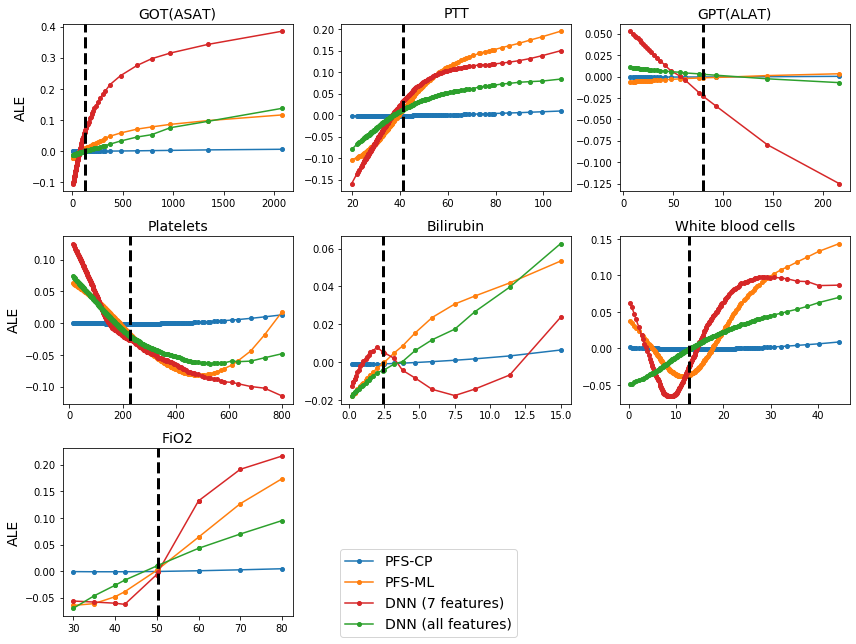

In [531]:
#Trim a bit of the start & tali of each series for plots without large interpolations
plot_locations = [0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0]
fig, axes = plt.subplots(3,3, figsize=(12,9))

for i, (row, col) in enumerate(plot_locations):
    axes[row,col].plot(exp_pfs_cp['feature_values'][i][1:-2]*stds[pfs_feats_indices[i]]+means[pfs_feats_indices[i]],
                       exp_pfs_cp['ale_values'][i][1:-2], 
                       label='PFS-CP',
                       color=colors[0],
                       marker='o',
                       markersize=4)
    
    axes[row,col].plot(exp_pfs_ml['feature_values'][i][1:-2]*stds[pfs_feats_indices[i]]+means[pfs_feats_indices[i]],
                       exp_pfs_ml['ale_values'][i][1:-2],
                       label='PFS-ML',
                       color=colors[1],
                       marker='o',
                       markersize=4)
    axes[row,col].plot(exp_dnn_pfs_feats['feature_values'][i][1:-2]*stds[pfs_feats_indices[i]]+means[pfs_feats_indices[i]],
                       exp_dnn_pfs_feats['ale_values'][i][1:-2],
                       label='DNN (7 features)',
                       color=colors[3],
                       marker='o',
                       markersize=4)
    axes[row,col].plot(exp_dnn_all_feats['feature_values'][pfs_feats_indices[i]][1:-2]*stds[pfs_feats_indices[i]]+means[pfs_feats_indices[i]],
                       exp_dnn_all_feats['ale_values'][pfs_feats_indices[i]][1:-2],
                       label='DNN (all features)',
                       color=colors[2],
                       marker='o',
                       markersize=4)

    axes[row,col].axvline(means[pfs_feats_indices[i]], linestyle='--', color='black', linewidth=3)

    axes[row,col].set_title(feature_names[i], fontsize=14)

    if col==0:
        axes[row,col].set_ylabel('ALE', fontsize=14)

axes[2,1].axis('off')
axes[2,2].axis('off')

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=14)

fig.tight_layout()

# fig.savefig(os.path.join(figs_base_path, 'ALEs-pfs-feats.png'),
#             dpi=200)

In [525]:
#Robustness check: Would the number of bins influence the shape of the ALEs? 
#Let's pick the DNN with 7 features on white blood cells - how does the curve change?
#Runs in ~40 minutes
min_bin_points_grid = [4,10,20,50,100,200,400,800,1600, 3200, 6400, 12800]
exp_results = []
for min_bin_points in min_bin_points_grid:
    print(min_bin_points)
    ale = ALE(predictor=dnn_pfs_feats_predictor, feature_names=feature_names)
    exp = ale.explain(X=X_test[:, pfs_feats_indices], min_bin_points=min_bin_points)
    exp_results.append(exp)

4
10
20
50
100
200
400
800
1600
3200
6400
12800


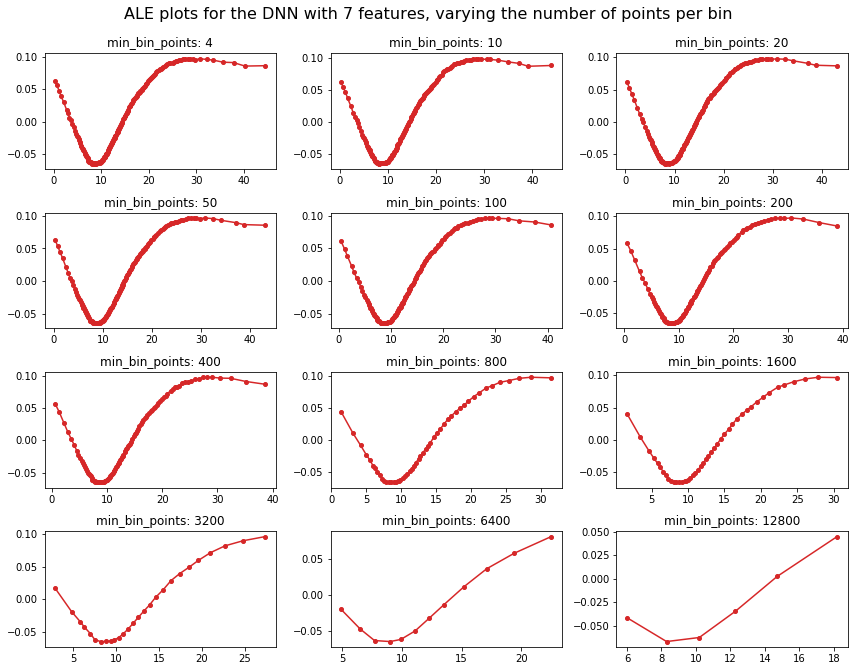

In [539]:
#Visualize ALE with different settings
fig, axes = plt.subplots(4,3, figsize=(12,9))
counter = 0 #Which min_bin_points value
i = 5 #White blood cells is the sixth feature, i.e. i=5
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        exp_dnn_pfs_feats = exp_results[counter]
        axes[row,col].plot(exp_dnn_pfs_feats['feature_values'][i][1:-2]*stds[pfs_feats_indices[i]]+means[pfs_feats_indices[i]],
                       exp_dnn_pfs_feats['ale_values'][i][1:-2],
                       label='DNN (7 features)',
                       color=colors[3],
                       marker='o',
                       markersize=4)
        # axes[row, col].plot(exp_results[counter]['feature_values'][6], exp_results[counter]['ale_values'][6], marker='.', color=colors[3])
        axes[row, col].set_title(f"min_bin_points: {exp_results[counter].params['min_bin_points']}")
        counter+=1

fig.suptitle('ALE plots for the DNN with 7 features, varying the number of points per bin', fontsize=16, y=1.03)
fig.tight_layout()
# fig.savefig(os.path.join(figs_base_path, 'ALE-bins-test.png'),
#             dpi=200)

Thus, it seems that the number of points per bin (i.e. where the borders of the intervals lie) does not matter too much - it is about the resolution of the ALE. This is probably because the effects are "accumulated".

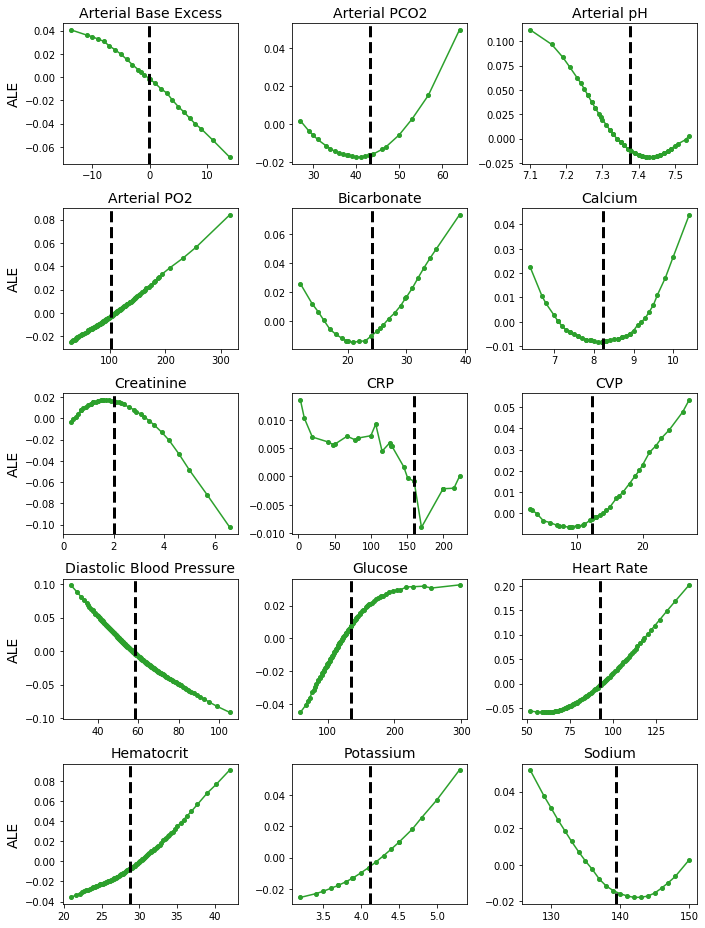

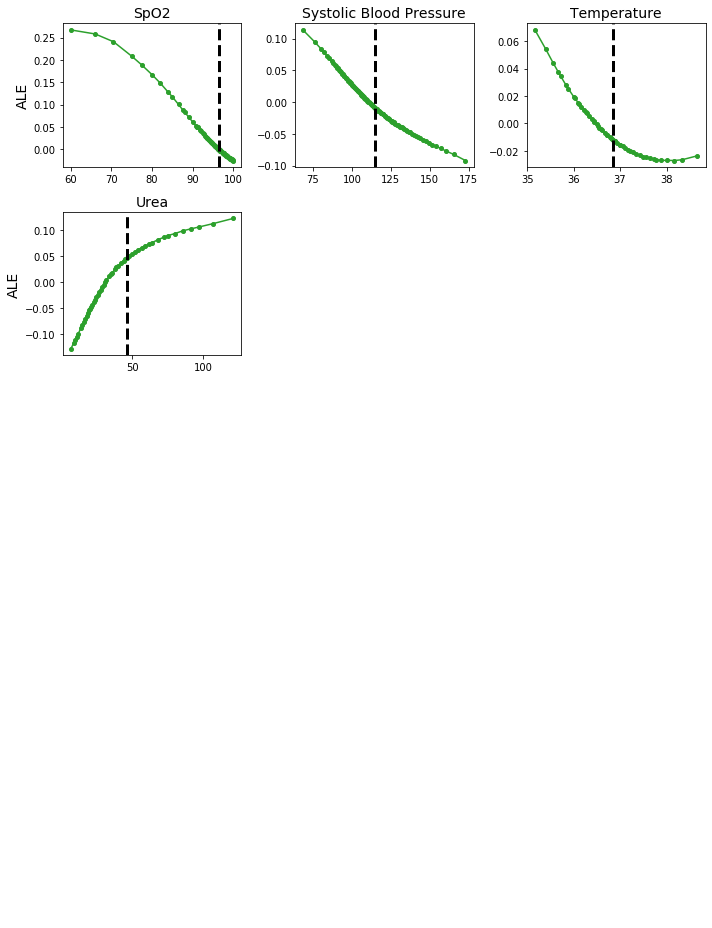

In [126]:
#ALE for DNN on the remaining features
rem_feature_indices = [i for i in range(X_test.shape[1]) if i not in pfs_feats_indices] #Store column indices for remaining features
all_feature_names = df_perm_imp_long['Feature'].values
fig1, axes1 = plt.subplots(5,3,figsize=(10,13))
fig2, axes2 = plt.subplots(5,3,figsize=(10,13)) #Ensure same size
i = 0

#First plot
for row in range(axes1.shape[0]):
    for col in range(axes1.shape[1]):
        axes1[row,col].plot(exp_dnn_all_feats['feature_values'][rem_feature_indices[i]][1:-1]*stds[rem_feature_indices[i]]+means[rem_feature_indices[i]],
                            exp_dnn_all_feats['ale_values'][rem_feature_indices[i]][1:-1],
                            label='DNN (all features)',
                            color=colors[2],
                            marker='o',
                            markersize=4)

        axes1[row,col].axvline(means[rem_feature_indices[i]], linestyle='--', color='black', linewidth=3)
        axes1[row,col].set_title(all_feature_names[rem_feature_indices[i]], fontsize=14)
        
        if (col==0):
            axes1[row,col].set_ylabel('ALE', fontsize=14)
        
        i += 1

# handles, labels = axes1[0,0].get_legend_handles_labels()
# fig1.legend(handles, labels, loc='lower center', fontsize=14)
fig1.tight_layout()
# fig1.savefig(os.path.join(figs_base_path, 'ALE-dnn-remaining-feats-1.png'),
#             dpi=200)

#Second plot
for row in range(axes2.shape[0]):
    for col in range(axes2.shape[1]):
        if (i==len(rem_feature_indices)): #Then all the features have been plotted
            axes2[row,col].axis('off')
            continue

        if (i==15): #Manual correction due to bug in Alibi package
            axes2[row,col].plot(exp_dnn_all_feats['feature_values'][rem_feature_indices[i]][1:-2]*stds[rem_feature_indices[i]]+means[rem_feature_indices[i]],
                                exp_dnn_all_feats['ale_values'][rem_feature_indices[i]][1:-1],
                                label='DNN (all features)',
                                marker='o',
                                color=colors[2],
                                markersize=4)
        else:
            axes2[row,col].plot(exp_dnn_all_feats['feature_values'][rem_feature_indices[i]][1:-1]*stds[rem_feature_indices[i]]+means[rem_feature_indices[i]],
                                exp_dnn_all_feats['ale_values'][rem_feature_indices[i]][1:-1],
                                label='DNN (all features)',
                                marker='o',
                                color=colors[2],
                                markersize=4)

        axes2[row,col].axvline(means[rem_feature_indices[i]], linestyle='--', color='black', linewidth=3)

        axes2[row,col].set_title(all_feature_names[rem_feature_indices[i]], fontsize=14)
        if col==0:
            axes2[row,col].set_ylabel('ALE', fontsize=14)
        
        i += 1

axes2[1,1].axis('off')
axes2[1,2].axis('off')

# handles, labels = axes2[0,0].get_legend_handles_labels()
# fig2.legend(handles, labels, loc='lower center', fontsize=14)
fig2.tight_layout()
# fig2.savefig(os.path.join(figs_base_path, 'ALE-dnn-remaining-feats-2.png'),
#             dpi=200) #Trim manually for report

# Case study: predictions for a patient over time

In [127]:
#Overview with patient, and the number of observations with death & survival that they have
df_test.groupby('subject_id')['y'].agg(['count', lambda x: len(x)-sum(x), 'sum'])\
    .rename(columns={'count':'n_instances', 'sum':'n_y=1', '<lambda_0>':'n_y=0'})\
    .iloc[-100:]\
    .head(50)

n_instances  n_y=0  n_y=1
subject_id                           
65056               124     11    113
65267                60     60      0
65537               140    140      0
65604               454    344    110
65627               109    109      0
65630               192     46    146
65959               172     73     99
66307               403    306     97
66517               424    320    104
67423               191    191      0
67427                81      0     81
67906              1699   1699      0
67917                55     18     37
67976               188     78    110
68209                54     54      0
68965               267    267      0
69146               343    165    178
69246                27     27      0
71377               223    223      0
71576               166    166      0
71774                63     63      0
71798                88      0     88
71862               319    319      0
72678               951    951      0
73488               430    430      0
73695              2153   2009    144
73713               639    639      0
74456               190    190      0
74481                55      0     55
74701               810    687    123
74727               706    568    138
74857              1649   1557     92
76479                71     71      0
76890                89     89      0
77383               542    542      0
77511                37     37      0
77614               561    463     98
78038               243    243      0
78756                65     65      0
79310               796    663    133
79344                76     76      0
79511               152     55     97
79709               134     73     61
80518               428    345     83
81475               830    688    142
81770                42     42      0
82439               578    578      0
82904               365    365      0
83362               644    537    107
83643               139    139      0

Some interesting subjects:
* 5799 (1): Clearly increasing prediction later on. More dense points near the end (i.e. more frequent sampling). Counterexample of stable GRU behavior.
* 16840 (1): Clearly increasing prediction later on, stable GRU @end
* 30661 (1): models with fewer features do relatively well
* 31137 (1): all models do pretty well, GRU smooth
* 69146: GRU 7 features surprisingly stable

In [157]:
df_subj.shape

(637, 37)

In [156]:
df_subj.head()

subject_id           charttime  arterial base excess  arterial pco2  \
64708       31137 2120-04-15 20:51:00               -7.0000       104.0000   
64709       31137 2120-04-15 21:00:00               -7.0000       104.0000   
64710       31137 2120-04-15 21:10:00               -7.0000       104.0000   
64711       31137 2120-04-15 22:00:00               -7.0000       104.0000   
64712       31137 2120-04-15 22:03:00               -7.0000       104.0000   

       arterial ph  arterial po2  bicarbonate  bilirubin  calcium  creatinine  \
64708       7.0200      105.0000          nan        nan      nan         nan   
64709       7.0200      105.0000          nan        nan      nan         nan   
64710       7.0200      105.0000          nan        nan      nan         nan   
64711       7.0200      105.0000          nan        nan      nan         nan   
64712       7.0200      105.0000          nan        nan      nan         nan   

       crp  cvp  diastolic blood pressure     fio2  glucose  got(asat)  \
64708  nan  nan                       nan      nan      nan        nan   
64709  nan  nan                   89.0000 100.0000      nan        nan   
64710  nan  nan                   89.0000 100.0000      nan        nan   
64711  nan  nan                   89.0000 100.0000      nan        nan   
64712  nan  nan                   94.5000 100.0000      nan        nan   

       gpt(alat)  heart rate  hematocrit  platelets  potassium  ptt   sodium  \
64708        nan         nan     44.0000        nan     4.3000  nan 138.0000   
64709        nan         nan     44.0000        nan     4.3000  nan 138.0000   
64710        nan    120.0000     44.0000        nan     4.3000  nan 138.0000   
64711        nan    124.3333     44.0000        nan     4.3000  nan 138.0000   
64712        nan    133.0000     44.0000        nan     4.3000  nan 138.0000   

         spo2  systolic blood pressure  temperature  urea  white blood cells  \
64708     nan                      nan          nan   nan                nan   
64709     nan                 119.0000      35.7222   nan                nan   
64710 93.0000                 119.0000      35.7222   nan                nan   
64711 96.0000                 119.0000      35.7222   nan                nan   
64712 96.0000                 154.0000      35.7222   nan                nan   

                deathtime    time to death  y  pred_PFS-CP  pred_PFS-ML  \
64708 2120-05-01 22:30:00 16 days 01:39:00  0       0.0952       0.5957   
64709 2120-05-01 22:30:00 16 days 01:30:00  0       0.1070       0.8696   
64710 2120-05-01 22:30:00 16 days 01:20:00  0       0.1070       0.8696   
64711 2120-05-01 22:30:00 16 days 00:30:00  0       0.1070       0.8696   
64712 2120-05-01 22:30:00 16 days 00:27:00  0       0.1070       0.8696   

       pred_DNN (all features)  pred_DNN (7 features)  \
64708                   0.9846                 0.7239   
64709                   0.9897                 0.8550   
64710                   0.9933                 0.8550   
64711                   0.9925                 0.8550   
64712                   0.9867                 0.8550   

       pred_GRU (all features)  pred_GRU (7 features)  
64708                   0.8369                 0.6715  
64709                   0.9454                 0.8192  
64710                   0.9741                 0.9182  
64711                   0.9809                 0.9543  
64712                   0.9784                 0.9632

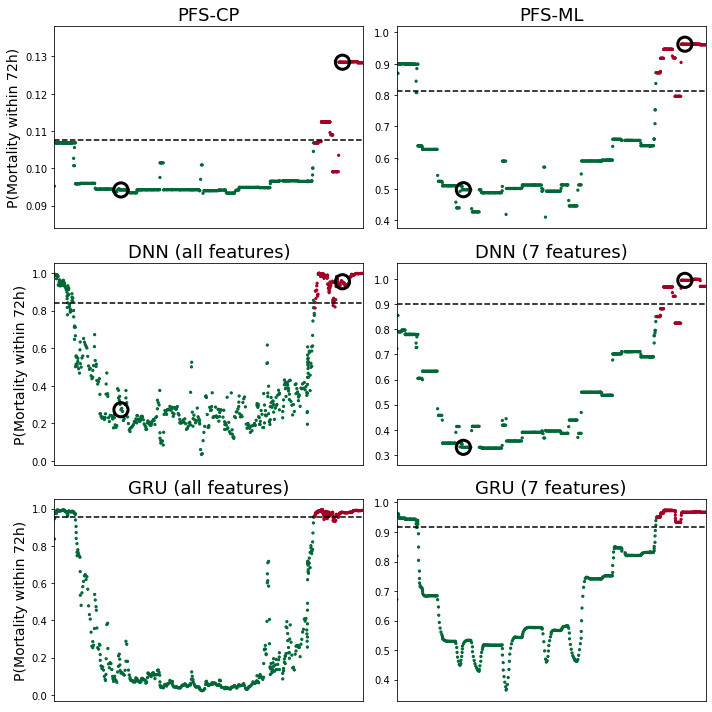

In [235]:
subject_id = 31137
lime_indices = [150,600]

fig, axes = plt.subplots(3,2,figsize=(10,10))
df_subj = df_test_w_preds[df_test_w_preds['subject_id']==subject_id]
pred_col_names = df_test_w_preds.columns[-6:]
modelnames = ['PFS-CP', 'PFS-ML', 'DNN (all features)', 'DNN (7 features)', 'GRU (all features)', 'GRU (7 features)']

lime_indices = [df_subj.index[0]+lime_indices[0], df_subj.index[0]+lime_indices[1]]

model_index = 0
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        axes[row,col].scatter(df_subj['charttime'], df_subj[pred_col_names[model_index]], c=df_subj['y'], cmap='RdYlGn_r', s=5) 
        if (row<2):
            axes[row,col].scatter(df_subj.loc[lime_indices,'charttime'], df_subj.loc[lime_indices,pred_col_names[model_index]], color='black', marker='o', s=200, linewidth=3, facecolors='none')
        axes[row,col].set_title(modelnames[model_index], fontsize=18)
        axes[row,col].set_xticks([],[]) #Turn off xticks to avoid messy, overlapping ticks
        axes[row,col].set_xlim(df_subj['charttime'].min(), df_subj['charttime'].max())
        
        axes[row,col].axhline(opt_thres[modelnames[model_index]], linestyle='--', color='black')
        # axes[row,col].set_ylim(0, df_subj[pred_col_names[model_index]].max())
        if (col==0):
            axes[row,col].set_ylabel('P(Mortality within 72h)', fontsize=14)
        model_index += 1

fig.tight_layout()
# fig.savefig(os.path.join(figs_base_path, 'case-study-1-time.png'),
#            dpi=200) #Trim manually for report

In [325]:
#Setup LIME explainers. Let's not use lasso feature selection
from lime.lime_tabular import LimeTabularExplainer
lime_te_dnn_all = LimeTabularExplainer(X_train,
                                       feature_names=all_feature_names,
                                       class_names=['Mortality'], 
                                    #    feature_selection='lasso_path',
                                       discretize_continuous=False)

lime_te_pfs = LimeTabularExplainer(X_train[:,pfs_feats_indices],
                                   feature_names=feature_names,
                                   class_names=['Mortality'],
                                #    feature_selection='lasso_path',
                                   discretize_continuous=False)

In [490]:
#Generate explanations for all models & selected instances

#Setup
expl_qualities = [] #For information relating to the quality of the explanation, i.e. fidelity as R^2, LIME prediction & actual prediction
features, modelnames, lime_coefs, instance_indices = [], [], [], [] #Information for the visualizations

for instance_index in lime_indices:
    #Generate the explanations using LIME
    pfs_cp_expl = lime_te_pfs.explain_instance(X_test[instance_index, pfs_feats_indices], pfs_cp.predict_proba, labels=[1], num_features=7)
    pfs_ml_expl = lime_te_pfs.explain_instance(X_test[instance_index, pfs_feats_indices], pfs_ml.predict_proba, labels=[1], num_features=7)
    dnn_pfs_feats_expl = lime_te_pfs.explain_instance(X_test[instance_index, pfs_feats_indices], dnn_pfs_feats.predict, labels=[0,], num_features=7)
    dnn_all_feats_expl = lime_te_dnn_all.explain_instance(X_test[instance_index], dnn_all_feats.predict, labels=[0,], num_features=7)
    
    #LIME output feature indices & coefficient values
    lime_out_pfs_cp = pfs_cp_expl.as_map()[1]
    lime_out_pfs_ml = pfs_ml_expl.as_map()[1]
    lime_out_dnn_pfs_feats = dnn_pfs_feats_expl.as_map()[0]
    lime_out_dnn_all_feats = dnn_all_feats_expl.as_map()[0]

    #Store info of the direct explanations for the plots
    instance_indices.extend([instance_index]*7*4)

    features.extend(
        list(np.array(feature_names)[np.array(lime_out_pfs_cp, dtype=int)[:,0]]) + \
        list(np.array(feature_names)[np.array(lime_out_pfs_ml, dtype=int)[:,0]]) + \
        list(np.array(feature_names)[np.array(lime_out_dnn_pfs_feats, dtype=int)[:,0]]) + \
        list(all_feature_names[np.array(lime_out_dnn_all_feats, dtype=int)[:,0]])
    )

    modelnames.extend(
        ['PFS-CP' for i in range(7)] + \
        ['PFS-ML' for i in range(7)] + \
        ['DNN (7 features)' for i in range(7)] + \
        ['DNN (all features)' for i in range(7)]
    )

    lime_coefs.extend(
        list(np.array(lime_out_pfs_cp)[:,1]) + \
        list(np.array(lime_out_pfs_ml)[:,1]) + \
        list(np.array(lime_out_dnn_pfs_feats)[:,1]) + \
        list(np.array(lime_out_dnn_all_feats)[:,1])
    )

    #Store infor regarding explanation quality
    expl_qualities.append([
        [instance_index, 'PFS-CP', pfs_cp_expl.score, pfs_cp_expl.local_pred[0], pfs_cp_expl.predict_proba[1]],
        [instance_index, 'PFS-ML', pfs_ml_expl.score, pfs_ml_expl.local_pred[0], pfs_ml_expl.predict_proba[1]],
        [instance_index, 'DNN (7 features)', dnn_pfs_feats_expl.score, dnn_pfs_feats_expl.local_pred[0], dnn_pfs_feats_expl.predict_proba[0]],
        [instance_index, 'DNN (all features)', dnn_all_feats_expl.score, dnn_all_feats_expl.local_pred[0], dnn_all_feats_expl.predict_proba[0]],
    ])

#Store as dataframe & neat long strings for figures later on
df_expl = pd.DataFrame([instance_indices, features, modelnames, lime_coefs], index=['Instance', 'Feature', 'Model', 'LIME Coefficient']).T
df_expl['Feature'] = df_expl['Feature'].str.replace(" ", '\n')
df_expl['Feature'] = df_expl['Feature'].str.replace("Temperature", 'Temp.')

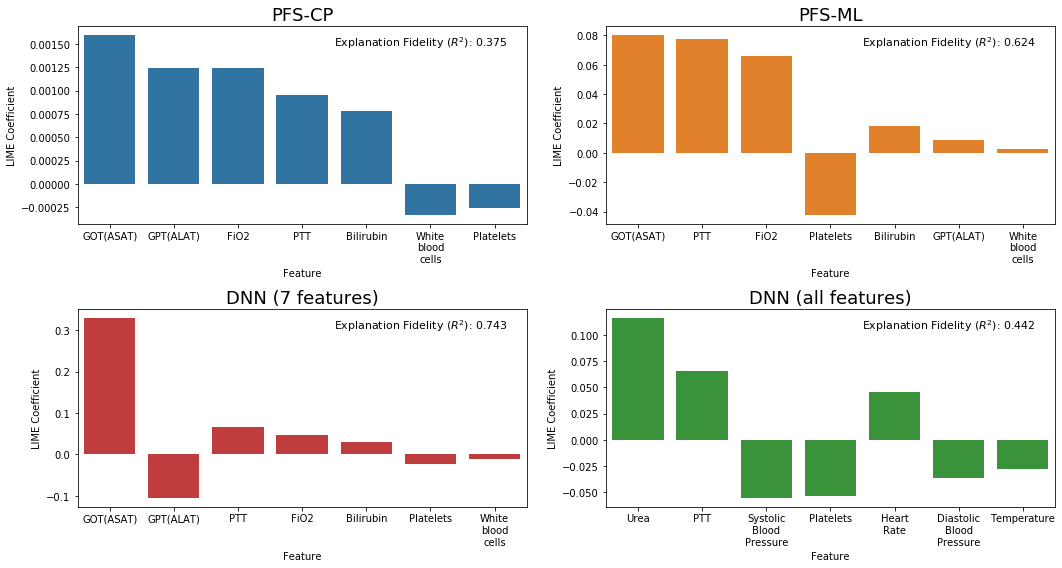

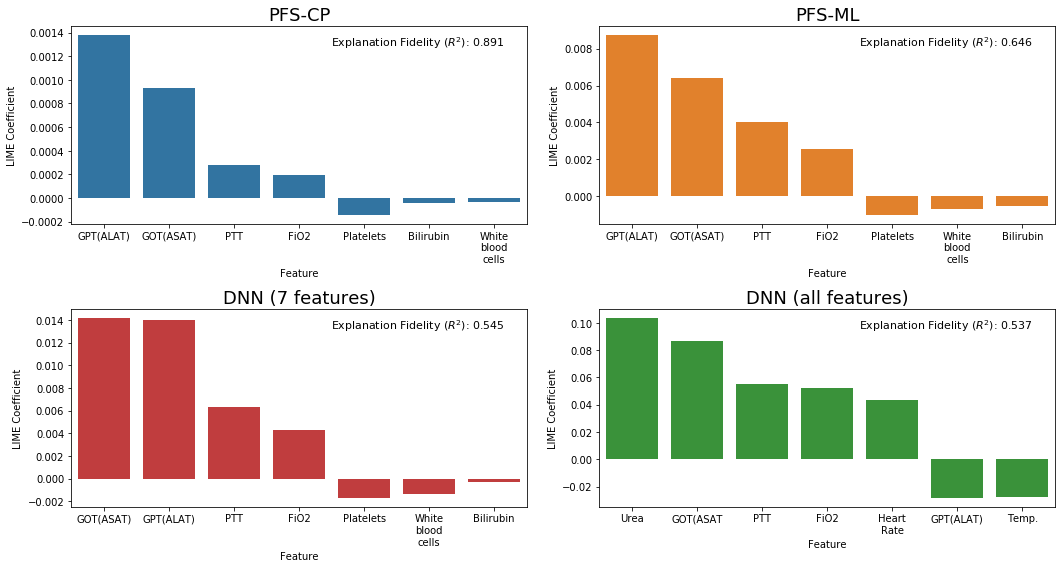

In [494]:
#Figures with lime explanations

#First figure
fig1, ax1 = plt.subplots(2,2, figsize=(15,8))
colors_dict = {
    'PFS-CP': colors[0],
    'PFS-ML': colors[1],
    'DNN (all features)': colors[2],
    'DNN (7 features)': colors[3]
}

sns.barplot(x='Feature',
            y='LIME Coefficient',
            ax=ax1[0,0], 
            data=df_expl[(df_expl['Instance']==lime_indices[0]) & (df_expl['Model']=='PFS-CP')],
            color=colors[0])

sns.barplot(x='Feature',
            y='LIME Coefficient',
            ax=ax1[0,1], 
            data=df_expl[(df_expl['Instance']==lime_indices[0]) & (df_expl['Model']=='PFS-ML')],
            color=colors[1])

sns.barplot(x='Feature',
            y='LIME Coefficient',
            ax=ax1[1,0], 
            data=df_expl[(df_expl['Instance']==lime_indices[0]) & (df_expl['Model']=='DNN (7 features)')],
            color=colors[3])

sns.barplot(x='Feature',
            y='LIME Coefficient',
            ax=ax1[1,1], 
            data=df_expl[(df_expl['Instance']==lime_indices[0]) & (df_expl['Model']=='DNN (all features)')],
            color=colors[2])

#Manual correction of xticklabels for more neat plot
ax1[1,1].set_xticklabels(['Urea', 'PTT', 'Systolic\nBlood\nPressure', 'Platelets','Heart\nRate', 'Diastolic\nBlood\nPressure', 'Temperature'])


#Set titles
ax1[0,0].set_title('PFS-CP', fontsize=18)
ax1[0,1].set_title('PFS-ML', fontsize=18)
ax1[1,0].set_title('DNN (7 features)', fontsize=18)
ax1[1,1].set_title('DNN (all features)', fontsize=18)

#Put fidelity in legend
ax1[0,0].annotate('Explanation Fidelity ($R^2)$: {:.3f}'.format(expl_qualities[0][0][2]), fontsize=11, xy=(0.57, 0.9), xycoords='axes fraction')
ax1[0,1].annotate('Explanation Fidelity ($R^2)$: {:.3f}'.format(expl_qualities[0][1][2]), fontsize=11, xy=(0.57, 0.9), xycoords='axes fraction')
ax1[1,0].annotate('Explanation Fidelity ($R^2)$: {:.3f}'.format(expl_qualities[0][2][2]), fontsize=11, xy=(0.57, 0.9), xycoords='axes fraction')
ax1[1,1].annotate('Explanation Fidelity ($R^2)$: {:.3f}'.format(expl_qualities[0][3][2]), fontsize=11, xy=(0.57, 0.9), xycoords='axes fraction')

fig1.tight_layout()

#Second figure
fig2, ax2 = plt.subplots(2,2, figsize=(15,8))

sns.barplot(x='Feature',
            y='LIME Coefficient',
            ax=ax2[0,0], 
            data=df_expl[(df_expl['Instance']==lime_indices[1]) & (df_expl['Model']=='PFS-CP')],
            color=colors[0])

sns.barplot(x='Feature',
            y='LIME Coefficient',
            ax=ax2[0,1], 
            data=df_expl[(df_expl['Instance']==lime_indices[1]) & (df_expl['Model']=='PFS-ML')],
            color=colors[1])

sns.barplot(x='Feature',
            y='LIME Coefficient',
            ax=ax2[1,0], 
            data=df_expl[(df_expl['Instance']==lime_indices[1]) & (df_expl['Model']=='DNN (7 features)')],
            color=colors[3])

sns.barplot(x='Feature',
            y='LIME Coefficient',
            ax=ax2[1,1], 
            data=df_expl[(df_expl['Instance']==lime_indices[1]) & (df_expl['Model']=='DNN (all features)')],
            color=colors[2])

#Set titles
ax2[0,0].set_title('PFS-CP', fontsize=18)
ax2[0,1].set_title('PFS-ML', fontsize=18)
ax2[1,0].set_title('DNN (7 features)', fontsize=18)
ax2[1,1].set_title('DNN (all features)', fontsize=18)

#Put fidelity in legend
ax2[0,0].annotate('Explanation Fidelity ($R^2)$: {:.3f}'.format(expl_qualities[1][0][2]), fontsize=11, xy=(0.57, 0.9), xycoords='axes fraction')
ax2[0,1].annotate('Explanation Fidelity ($R^2)$: {:.3f}'.format(expl_qualities[1][1][2]), fontsize=11, xy=(0.57, 0.9), xycoords='axes fraction')
ax2[1,0].annotate('Explanation Fidelity ($R^2)$: {:.3f}'.format(expl_qualities[1][2][2]), fontsize=11, xy=(0.57, 0.9), xycoords='axes fraction')
ax2[1,1].annotate('Explanation Fidelity ($R^2)$: {:.3f}'.format(expl_qualities[1][3][2]), fontsize=11, xy=(0.57, 0.9), xycoords='axes fraction')

fig2.tight_layout()

In [495]:
# fig1.savefig(os.path.join(figs_base_path,'lime-instance-1.png'),
#             dpi=200)
# fig2.savefig(os.path.join(figs_base_path,'lime-instance-2.png'),
#             dpi=200)

In [519]:
#What kernel width is used by default?
np.sqrt(X_train.shape[1])

5.0990195135927845

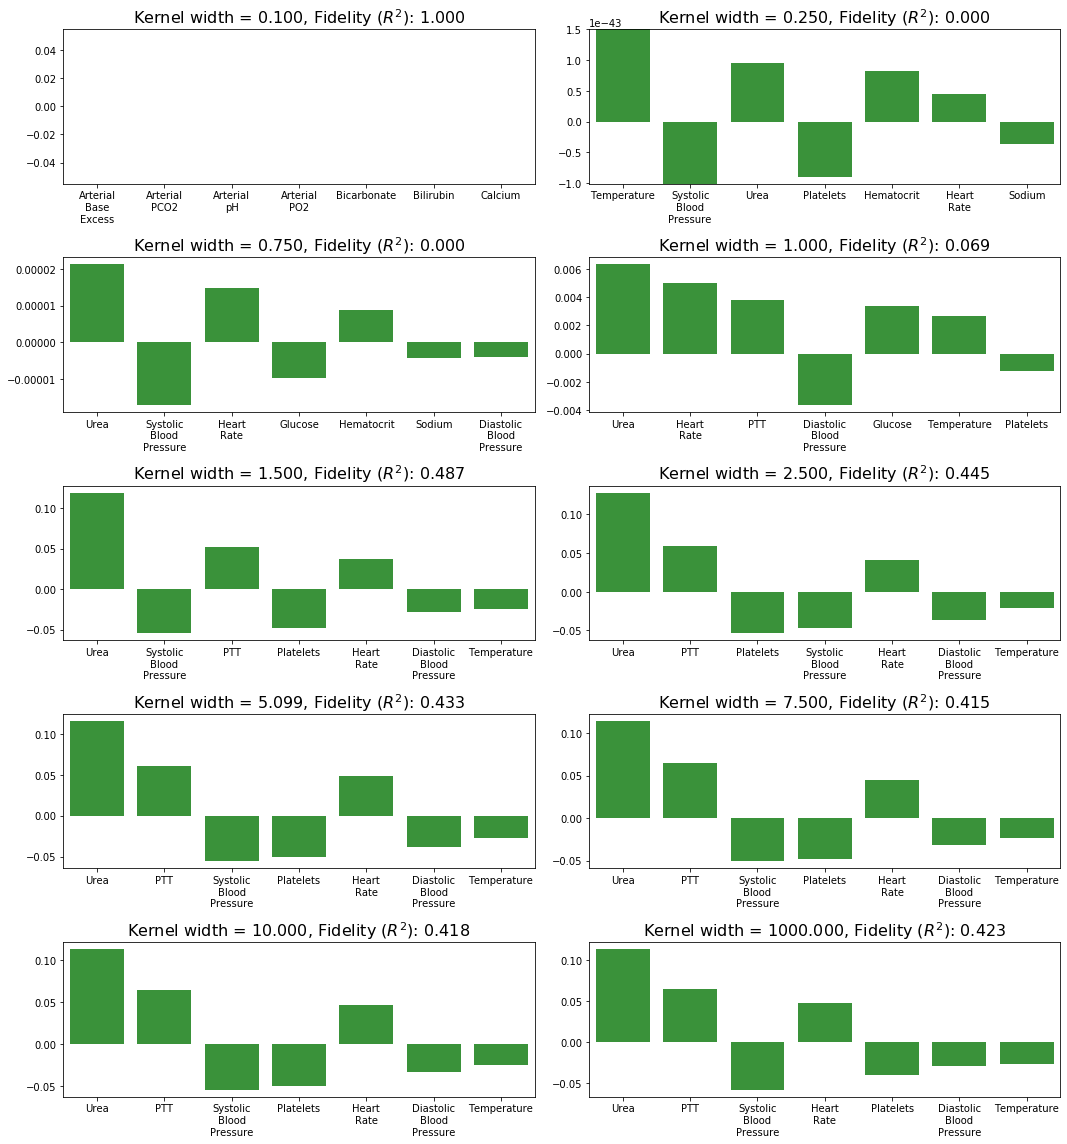

In [524]:
#Lime sensitivity analysis
#Investigate for DNN all features for the first instance. Fidelity is very low there, so could be highly likely that local surrogate model is 
#inappropriate and highly influenced by kernel width

kernel_widths_grid = [0.1, 0.25, 0.75, 1, 1.5, 2.5, np.sqrt(X_train.shape[1]), 7.5, 10, 1000]
fig, axes = plt.subplots(5, 2, figsize=(15,16))

i=0
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        lime_te_dnn_all = LimeTabularExplainer(X_train,
                                               feature_names=all_feature_names,
                                               class_names=['Mortality'], 
                                               discretize_continuous=False,
                                               kernel_width=kernel_widths_grid[i])
        expl = lime_te_dnn_all.explain_instance(X_test[lime_indices[0]], dnn_all_feats.predict, labels=[0,], num_features=7)
        lime_out_dnn_all_feats = expl.as_map()[0]
        fnames = [name.replace(" ", "\n") for name in all_feature_names[np.array(lime_out_dnn_all_feats, dtype=int)[:,0]]]
        sns.barplot(x=fnames,
                    y=np.array(lime_out_dnn_all_feats)[:,1],
                    ax=axes[row,col], 
                    color=colors[2])
        figtitle = 'Kernel width = {:.3f}'.format(kernel_widths_grid[i]) + ", Fidelity ($R^2$): {:.3f}".format(expl.score)
        axes[row,col].set_title(figtitle, fontsize=16)
        i += 1

fig.tight_layout()
# fig.savefig(os.path.join(figs_base_path,'lime-kernelwidth-analysis.png'),
#             dpi=200)

# Additional patient

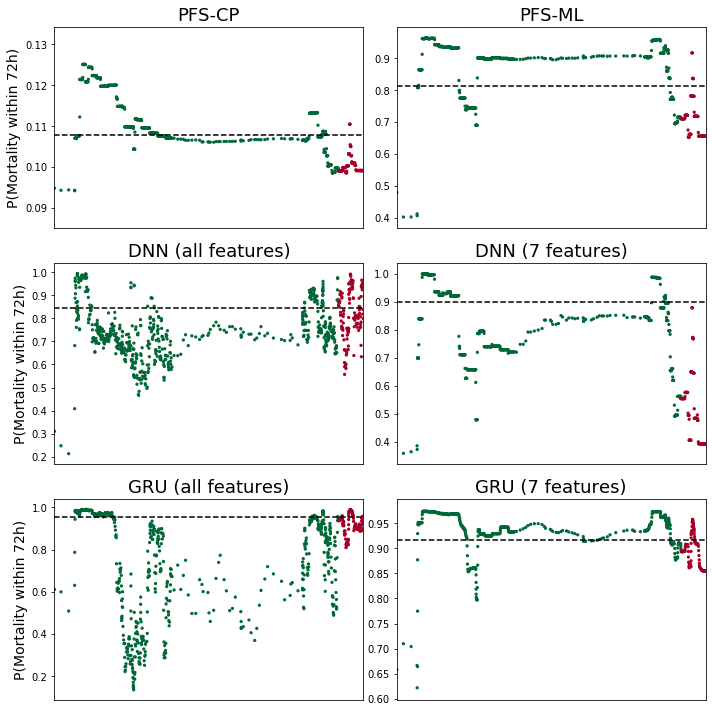

In [23]:
subject_id = 79310
lime_indices = [1,2]

fig, axes = plt.subplots(3,2,figsize=(10,10))
df_subj = df_test_w_preds[df_test_w_preds['subject_id']==subject_id]
pred_col_names = df_test_w_preds.columns[-6:]
modelnames = ['PFS-CP', 'PFS-ML', 'DNN (all features)', 'DNN (7 features)', 'GRU (all features)', 'GRU (7 features)']

lime_indices = [df_subj.index[0]+lime_indices[0], df_subj.index[0]+lime_indices[1]]

model_index = 0
for row in range(axes.shape[0]):
    for col in range(axes.shape[1]):
        axes[row,col].scatter(df_subj['charttime'], df_subj[pred_col_names[model_index]], c=df_subj['y'], cmap='RdYlGn_r', s=5) 
        # if (row<2):
            # axes[row,col].scatter(df_subj.loc[lime_indices,'charttime'], df_subj.loc[lime_indices,pred_col_names[model_index]], color='black', marker='o', s=200, linewidth=3, facecolors='none')
        axes[row,col].set_title(modelnames[model_index], fontsize=18)
        axes[row,col].set_xticks([],[]) #Turn off xticks to avoid messy, overlapping ticks
        axes[row,col].set_xlim(df_subj['charttime'].min(), df_subj['charttime'].max())
        
        axes[row,col].axhline(opt_thres[modelnames[model_index]], linestyle='--', color='black')
        # axes[row,col].set_ylim(0, df_subj[pred_col_names[model_index]].max())
        if (col==0):
            axes[row,col].set_ylabel('P(Mortality within 72h)', fontsize=14)
        model_index += 1

fig.tight_layout()
# fig.savefig(os.path.join(figs_base_path, 'case-study-2-time.png'),
#             dpi=200) #Trim manually for report